# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")


import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [40]:
from polcanet import LinearDecoder, PolcaNet, PolcaNetLoss
from polcanet.example_aencoders import (
    ConvEncoder,
    DenseDecoder,
    DenseEncoder,
    LSTMEncoder,
    MinMaxScalerTorch,
    StandardScalerTorch,
)

In [41]:
import polcanet.polcanet_reports as report

In [46]:
import utils as ut 

In [6]:
np.random.seed(5)

In [7]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [8]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="data/MNIST", train=True, download=True, transform=None)

In [9]:
train_dataset = mnist_trainset.data[:-10000].reshape(-1, 28, 28) / 255.0
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 28, 28) / 255.0
y_train = mnist_trainset.targets[:-10000].numpy()
y_test = mnist_trainset.targets[-10000:].numpy()
X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y_train.shape, y_test.shape

(torch.Size([50000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (50000, 28, 28),
 (10000, 28, 28),
 (50000,),
 (10000,))

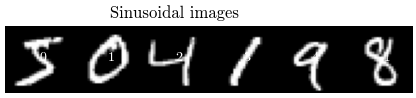

In [10]:
def plot_train_images(x, title, n=1):
    # Plot original and reconstructed signals for a sample
    fig, axes = plt.subplots(1, n + 1)
    fig.subplots_adjust(wspace=0.01)
    im_list = list(range(n)) + [-1]
    for i in im_list:
        axes[i].imshow(x[i], cmap="gray")
        if i==n//2:
            axes[i].set_title(f"{title}")
        axes[i].axis("off")
        axes[i].text(x[i].shape[0] // 2, x[i].shape[1] // 2, str(i),color="white")

    plt.show()

plot_train_images(X, "Sinusoidal images", n=5)

### Fit standard sklearn PCA

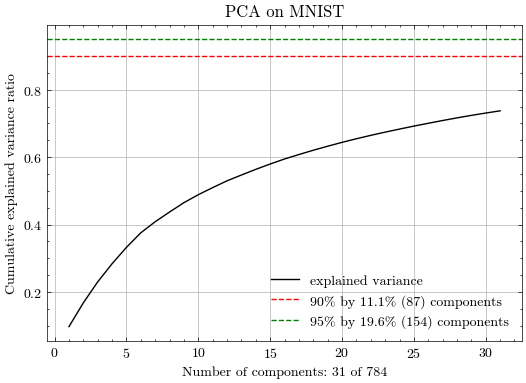

In [11]:
n_components = int(np.prod(X.shape[1:]) // 25)
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca = get_pca(X,n_components=n_components,title="PCA on MNIST",ax=axs,)
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [12]:
N = X[0].shape[0]
M = X[0].shape[1]

In [13]:
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=512,
    num_layers=5,
    act_fn=act_fn
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim ,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device=device,   
)
model

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): SiLU()
          (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (9): SiLU()
          (10): Flatten(start_dim=1, end_dim=-1)
          (11): Linear(in_features=128, out_features=124, bias=True)
          (12): SiLU()
          (13): Linear(in_features=124, out_features=31, bias=True)
        )
      )
      (1): Tanh()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=31, out_features=512, bias

In [14]:
# train_dataloader = DataLoader(X, batch_size=2*512, shuffle=True,num_workers=0)
# test_dataloader = DataLoader(X_test, batch_size=2*512, shuffle=True, num_workers=0)

In [15]:
model.to(device)
model.train_model(data=X,batch_size=2*512, num_epochs=2000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Final metrics at epoch: 2000
Total Loss: 0.008879
Reconstruction Loss: 0.004384
Orthogonality Loss: 0.001404
Center of Mass Loss: 0.001881
Variance Distribution Loss: 0.0006981


0.008878787865444106

In [16]:
model.train_model(data=X,batch_size=2*512, num_epochs=2000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Final metrics at epoch: 2000
Total Loss: 0.007225
Reconstruction Loss: 0.003732
Orthogonality Loss: 0.001056
Center of Mass Loss: 0.001544
Variance Distribution Loss: 0.0007022


0.007224556457783494

In [17]:
model.train_model(data=X, batch_size=2*512, num_epochs=2000, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Final metrics at epoch: 2000
Total Loss: 0.006922
Reconstruction Loss: 0.003636
Orthogonality Loss: 0.0009266
Center of Mass Loss: 0.001505
Variance Distribution Loss: 0.0006993


0.006922411741878913

## Evaluate results

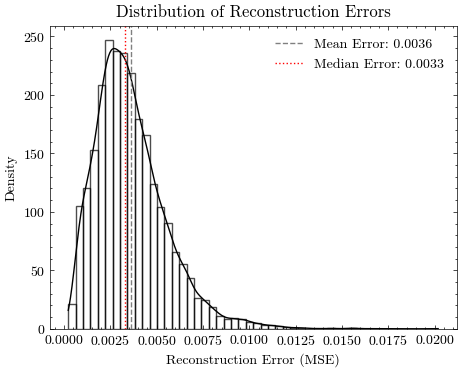

Mean Reconstruction Error: 0.0036
Median Reconstruction Error: 0.0033
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0202


In [18]:
report.analyze_reconstruction_error(model, X[:-20000])

In [19]:
latents, reconstructed = model.predict(X)

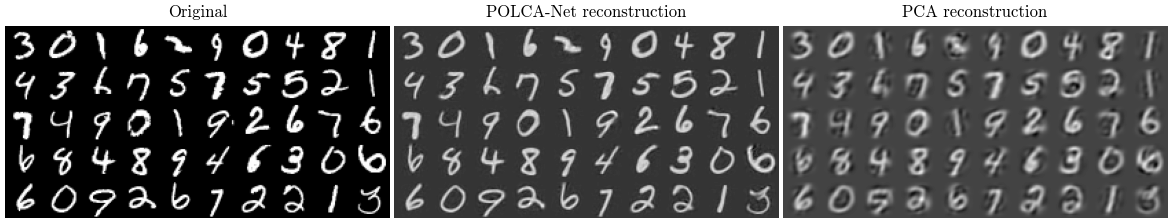

In [47]:
# Assuming images are properly defined as before
images = X_test[0:50]

# Reconstruct and visualise the images using the autoencoder
_, ae_reconstructed = model.predict(images)

# Reconstruct and visualize the imagaes by PCA
pca_latents = pca.transform(images.reshape(images.shape[0], -1))
pca_reconstructed = pca.inverse_transform(pca_latents)
pca_reconstructed = pca_reconstructed.reshape(images.shape[0], N, M)

ut.visualise_reconstructed_images(
    [images, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "POLCA-Net reconstruction", "PCA reconstruction"],
    cmap="gray",nrow=10,
)

In [21]:
report.analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 31
Total variance in latent space: 0.0048

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4838
First 5 components              0.9989
Components for 95% variance     3
Variance Concentration Metric   0.9754

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0019
Median absolute off-diagonal          0.0011
Max absolute off-diagonal             0.0303
Proportion of |Orthogonality| > 0.1   0
Orthogonality Success Metric          0.9981

Orthogonality Interpretation:
Excellent orthogonality of features.

4. D


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0012
    - Max cosine similarity: 0.1076
    - Min cosine similarity: -0.0975
    


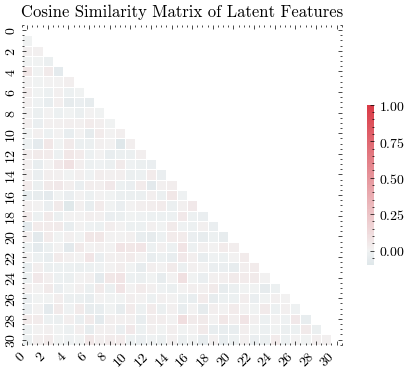

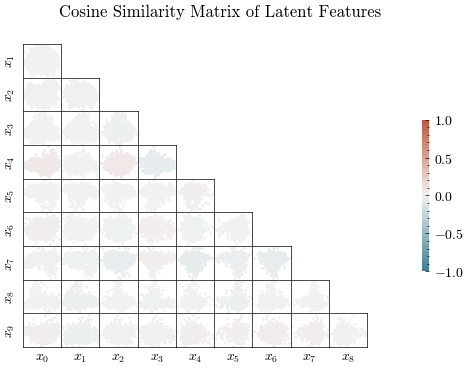

In [22]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.7715
    - Variance fit to exponential distribution (sum of squared differences):
     0.0393
    


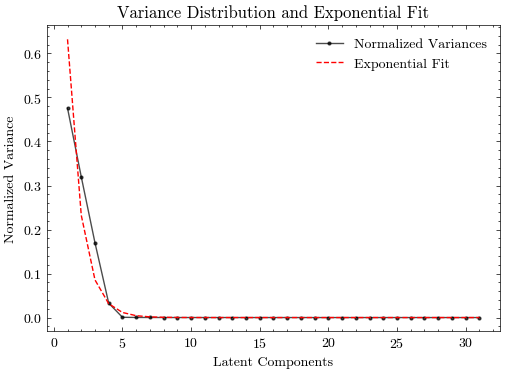

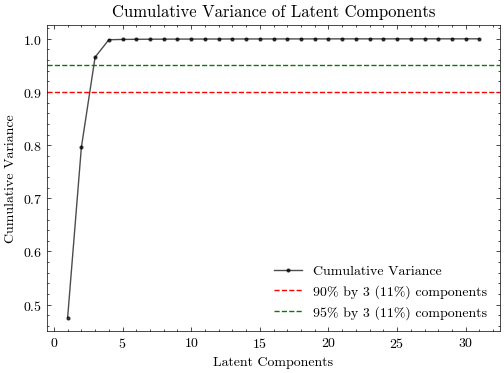

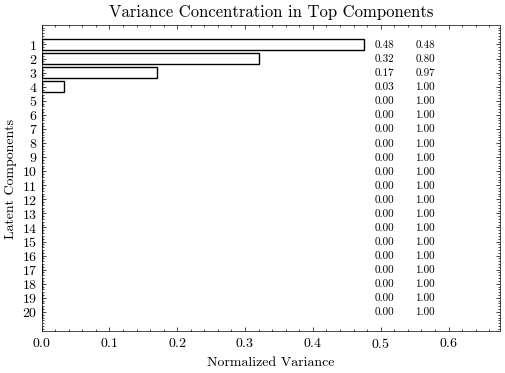

In [23]:
report.variance_test_analysis(model, X)

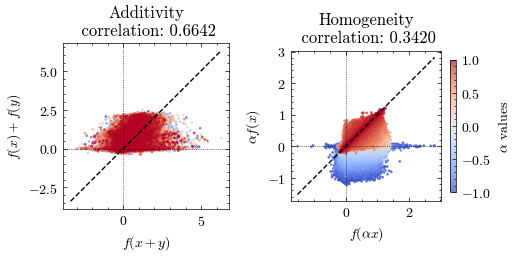

In [24]:
report.linearity_tests_analysis(model, X)

In [25]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [26]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y_train, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y_train, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

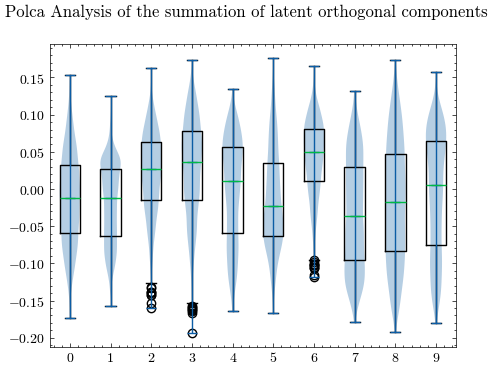

In [27]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y_train == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [28]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

## Test Classification with two components on PCA vs POLCA Net

In [29]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale, scale
from sklearn.svm import SVC

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.3, random_state=1)

In [31]:
X_train_pca = pca.transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))
X_train_pca.shape, X_test_pca.shape

((35000, 31), (15000, 31))

In [32]:
# Transform the data using POLCA-Net
# X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:, :pca.n_components]
# X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:, :pca.n_components]
X_train_polca.shape, X_test_polca.shape

((35000, 31), (15000, 31))

In [33]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(solver='saga',n_jobs=30,max_iter=500),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(n_jobs=30),
}

In [34]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []
from tqdm.auto import tqdm
for name, clf in tqdm(classifiers.items()):
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)

    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_pca,
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_polca,
        }
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=["Confusion Matrix"])
main_metrics_df["n_components"] = pca.n_components
main_metrics_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score,n_components
0,Logistic Regression,PCA,0.877133,0.880347,0.877133,0.876878,31
1,Logistic Regression,POLCA-Net,0.895600,0.905198,0.895600,0.897041,31
2,Gaussian Naive Bayes,PCA,0.844667,0.853883,0.844667,0.846207,31
3,Gaussian Naive Bayes,POLCA-Net,0.891733,0.894967,0.891733,0.892482,31
4,Linear SVM,PCA,0.908533,0.910343,0.908533,0.908250,31
5,Linear SVM,POLCA-Net,0.913800,0.919334,0.913800,0.914248,31
6,Ridge Classifier,PCA,0.814667,0.819448,0.814667,0.811480,31
7,Ridge Classifier,POLCA-Net,0.853533,0.861875,0.853533,0.853024,31
8,Perceptron,PCA,0.811467,0.829242,0.811467,0.801856,31
9,Perceptron,POLCA-Net,0.773733,0.884564,0.773733,0.800574,31


In [36]:
# Statistical test: Paired t-test for accuracies
comparison_metrics = ["Accuracy","Precision","Recall","F1-Score"]
print(f"\nPaired t-test results:") 
for comparison_metric in comparison_metrics:

    print(f"{comparison_metric}:")
    pca_result = results_df[results_df["Transformation"] == "PCA"][comparison_metric]
    polca_result = results_df[results_df["Transformation"] == "POLCA-Net"][comparison_metric]    
    t_stat, p_value = ttest_rel(pca_result.values, polca_result.values)    
    print(f"\tt-statistic = {t_stat}, p-value = {p_value}, p-value threshold < {0.05}")    
    if p_value < 0.05:
        #print(f"There is a statistically significant difference between the PCA and POLCA-Net transformations")
        ans = "a"
    else:
        ans = "no"
    
    print(f"\tThere is {ans} statistically significant difference between the PCA and POLCA-Net transformations.")


Paired t-test results:
Accuracy:
	t-statistic = -0.9608670452485033, p-value = 0.3910320987512572, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Precision:
	t-statistic = -4.310922070264489, p-value = 0.012536906686514877, p-value threshold < 0.05
	There is a statistically significant difference between the PCA and POLCA-Net transformations.
Recall:
	t-statistic = -0.9608670452485033, p-value = 0.3910320987512572, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
F1-Score:
	t-statistic = -2.395070027242382, p-value = 0.0747551207248428, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.


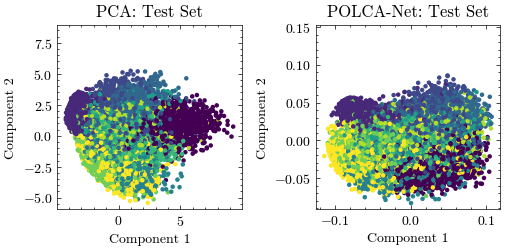

In [72]:
# Plotting the results
plt.figure()

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="viridis", edgecolor=None, s=5)
plt.title("PCA: Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("square")

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 2], c=y_test, cmap="viridis", edgecolor=None, s=5)
plt.title("POLCA-Net: Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("square")

plt.tight_layout()
plt.show()

In [ ]:
experiment_data = {
    "MNIST" : (X_test,model,pca),   
}
df_image_metrics = ut.image_metrics_table(experiment_data)

In [81]:
display(df_image_metrics.reset_index().style.hide())
print(df_image_metrics.reset_index().style.hide().to_latex())

Method,Normalized Mean Squared Error,Peak Signal-to-Noise Ratio,Structural Similarity Index
POLCA-Net MNIST,0.034100,73.147400,0.999900
PCA MNIST,0.172200,65.971800,0.999400


\begin{tabular}{lrrr}
Method & Normalized Mean Squared Error & Peak Signal-to-Noise Ratio & Structural Similarity Index \\
POLCA-Net MNIST & 0.034100 & 73.147400 & 0.999900 \\
PCA MNIST & 0.172200 & 65.971800 & 0.999400 \\
\end{tabular}

